In [7]:
using JLD, Plots, Combinatorics
using HDF5
using Base.Iterators
gr()

Plots.GRBackend()

In [9]:
arxname="../JLDFiles/Evocada/CSDEvocada_3R7.jld"
data=load(arxname)
arxotro="/home/karel/BRWFiles/Evocada05082015/LFP_Promedio_050815_3R3_converted.jld"
#arxaux=h5open(arxotro)
#h5close(arxaux)
cresp=read(arxaux["CanalesRespuesta"])
csatu=read(arxaux["CanalesSaturados"]);

UndefVarError: UndefVarError: arxaux not defined

In [4]:
freq=7.022
csd=(data["CSD"]["Trancazo_1"]+data["CSD"]["Trancazo_2"]+data["CSD"]["Trancazo_3"])./3
(h,w,nmax)=size(csd)
epsi=21
  ss=[-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

In [5]:
size(csd)

(62, 62, 248)

In [5]:
function simboliza(x, delta=epsi)
    result=0
    if x>delta
        result=1
    elseif x< -delta
        result=-1
    else
        result=0
    end
    return result
end

simboliza (generic function with 2 methods)

In [6]:
csdsymb=map(x->simboliza(x), csd);

In [7]:
xs=csdsymb[16,28,:];
ys=[1]

1-element Array{Int64,1}:
 1

In [8]:
function problock(xxs::Array, yys::Array)
    # calculamos la prob exp de encontrar el array yys en el array xxs
    lx=length(xxs)
    ly=length(yys)
    lp=lx-ly+1
    result=0
    if(lx<ly)
        error("tuabueliuta")
    else
        for j=1:lp
            if xxs[j:j+ly-1]==yys
                result+=1
            end
        end
    end
    return result/lp
end

problock (generic function with 1 method)

In [9]:
function ncartprod(ss, n)
    argumento=ntuple(i->ss, n)
    result=product(argumento...)
    return(result)
end

ncartprod (generic function with 1 method)

In [10]:
function ncartprodR(ss, n)
# okey, esto no funciona nada bien. Muuuy lento y usa mas RAM
    # Y PRODUCE UN OBJETO monstruoso en RAM
    result=[]
    if n==1
        for s in ss
            push!(result, [s])
        end
        return result
    else
        aux=ncartprodR(ss, n-1)
        for w in aux
            for s in ss
                vv=vcat(s, w)
                push!(result, vv)
            end
        end
        return result
    end
end

ncartprodR (generic function with 1 method)

In [11]:
n=3
@time a=ncartprodR(ss, n);
@time b=ncartprod(ss, n);

  0.250577 seconds (659.26 k allocations: 33.015 MiB, 2.28% gc time)
  0.047972 seconds (127.82 k allocations: 6.478 MiB)


In [13]:
Base.summarysize(a), Base.summarysize(b)

(1984, 96)

In [14]:
# con permiso de StackOverflow oooo.key takes lot to compile!
issubvec(v,big) = any([v == big[i:(i+length(v)-1)] for i=1:(length(big)-length(v)+1)])

issubvec (generic function with 1 method)

In [15]:
function allprobsn(xxs, ss, n)
    result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        aux=problock(xxs, pr)
        if aux>0
            result[pr]= aux
        else
            push!(malas, pr)
        end
    end
    return (result, malas)
end


function allprobsn(xxs, ss, n, vacias)
    
    #ush tambien muy ineficiente. Sigue siendo mejor buscar a lo pendejo???
            result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        tanteada=any(issubvec(v, pr) for v in vacias)
        if tanteada
         #   print(pr, " esta tanteada!!  ")
            aux=0
        else
            aux=problock(xxs, pr)
            if aux>0
                result[pr]= aux
            else
                push!(malas, pr)
            end
        end # sobre tanteada
    end #sobre palabras
    return (result, malas)
end

allprobsn (generic function with 2 methods)

In [17]:
function allprobsR(xxs, ss, n)
#not reaaalyy good. Actually preeeety bad
     result=Dict{Array, Float64}()
    if n==1
        palabras=ncartprod(ss, n)
        for p in palabras
            pr=[p...]
            result[pr]=problock(xxs, pr)
        end
    
    else
        
        auxres=allprobsR(xxs,ss,n-1)
        vacias=Set()
        for v in keys(auxres)
            if auxres[v]==0
                push!(vacias, v)
            end
        end
        
        palabras=ncartprod(ss, n)
        for p in palabras
            pr=[p...]
            tienemala=any(issubvec(v, pr) for v in vacias)
            if tienemala
                result[pr]=0
            else
                result[pr]=problock(xxs, pr)
            end
        end
        
        end  # cierra sobre n
    
    return result
end
                
                
    
    

allprobsR (generic function with 1 method)

Haciendo pruebas, al parecer matar el conjunto de malas con entre 3 y 4 letras es la forma más rapida. Ya despues de eso tiene que revisar palabrerias tan largas que no conviene.

In [18]:
@time (p, v3)=allprobsn(xs, ss, 3)

  0.380981 seconds (838.20 k allocations: 42.104 MiB, 3.02% gc time)


(Dict{Array,Float64}([1, -1, -1]=>0.00813008,[0, -1, -1]=>0.00813008,[-1, -1, 0]=>0.0162602,[0, 0, 0]=>0.829268,[-1, 0, -1]=>0.00406504,[1, 0, 1]=>0.0121951,[1, 1, 1]=>0.0203252,[0, 1, -1]=>0.00406504,[0, 1, 0]=>0.00813008,[0, -1, 0]=>0.00406504…), Set(Any[[-1, 0, 1], [0, -1, 1], [-1, 1, 0], [-1, 1, -1], [1, 0, -1], [-1, -1, 1], [-1, 1, 1], [1, -1, 1], [1, -1, 0]]))

In [19]:
@time (p, v)=allprobsn(xs, ss, 11)

  4.721828 seconds (44.13 M allocations: 7.087 GiB, 43.29% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]=>0.00420168,[0, 0, 0, 0, 0, 1, -1, -1, -1, 0, -1]=>0.00420168,[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]=>0.00420168,[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1]=>0.00420168,[0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0]=>0.00420168,[1, 1, -1, -1, 0, 0, -1, -1, -1, 0, 0]=>0.00420168,[0, 0, 0, 0, 1, -1, -1, -1, 0, -1, 0]=>0.00420168,[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]=>0.00420168,[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]=>0.00420168,[1, 1, 1, -1, -1, 0, 0, -1, -1, -1, 0]=>0.00420168…), Set(Any[[-1, -1, -1, -1, -1, -1, -1, 1, 0, 1, -1], [1, -1, 0, -1, 1, -1, 1, -1, 1, 0, 0], [-1, 0, -1, 0, 0, 0, -1, 0, -1, 1, 0], [1, -1, 0, 1, 1, 1, 1, 1, 1, -1, 1], [1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 0], [-1, -1, 0, 0, -1, -1, -1, 0, 1, 1, -1], [-1, 0, 0, -1, -1, -1, 1, 0, 1, 1, 0], [1, -1, 0, 1, 1, 0, 1, 1, 1, 0, -1], [-1, -1, -1, 0, 1, 0, 0, 1, 1, 1, 0], [-1, 1, -1, 0, 1, 1, -1, 0, 0, 0, 1]  …  [1, 0, -1, 0, 0, 1, 0, 0, -1, -1, -1], [0, 1, 1, -1, -1, 0, 1, -1, -1, -1, -1], [1, 1, 1, 1,

In [112]:
length(v4)

51

In [20]:
@time (ar, ir)=allprobsn(xs, ss,11, v3)

  1.079805 seconds (11.53 M allocations: 1.301 GiB, 28.15% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]=>0.00420168,[0, 0, 0, 0, 0, 1, -1, -1, -1, 0, -1]=>0.00420168,[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]=>0.00420168,[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1]=>0.00420168,[0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0]=>0.00420168,[1, 1, -1, -1, 0, 0, -1, -1, -1, 0, 0]=>0.00420168,[0, 0, 0, 0, 1, -1, -1, -1, 0, -1, 0]=>0.00420168,[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]=>0.00420168,[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]=>0.00420168,[1, 1, 1, -1, -1, 0, 0, -1, -1, -1, 0]=>0.00420168…), Set(Any[[1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 0], [1, -1, -1, -1, 0, 0, 1, 0, 0, -1, 0], [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1], [-1, -1, 0, -1, -1, -1, 0, 0, 0, -1, 0], [0, 0, -1, -1, 0, 0, 1, 1, 1, 1, 1], [-1, -1, -1, 0, -1, -1, 0, 0, 0, 1, 1], [0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0], [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, -1], [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1], [0, -1, 0, 0, -1, -1, 0, 0, 1, 1, -1]  …  [1, 1, 1, -1, -1, 0, 0, 0, 1, -1, -1], [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, -1], [1, 0, 1, 0, 1, 1, 0, 0, 

In [71]:
function shanonH_n(xxs, ss, n)
    (probs, v)=allprobsn(xxs,ss,n)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(xxs, ss, n, v)
    (probs, v)=allprobsn(xxs,ss,n, v)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h/n
    return result
end

function shanonH_n(probs,n)
    #meter un dict con probs>0 porfis
    h=0
    for q in values(probs)
        h+=q*log(q)
    end
    result=-h/n
    return result
end

shanonH_n (generic function with 4 methods)

In [122]:
struct hazfibrado
    renglon::Int
    columna::Int
    valores::Array{Float64, 1}
end

In [28]:
lmax, bla =size(cresp)

(203, 2)

In [77]:
nm=div(nmax,2)
hhsn=Dict{Array{Int, 1}, Array{Float64,1}}()
hhsn2=Dict{Array{Int, 1}, Array{Float64,1}}()
arbol=Dict{Array{Int,1}, Dict{Int, Array}}()
nn=8
@time for l=1:lmax
        reng=cresp[l, 1]
        col=cresp[l, 2]
    if reng<63 && col <63
        xs=csdsymb[reng,col,:]
        hhsn[[reng,col]]=zeros(nn)
        hhsn2[[reng,col]]=zeros(nn)
        arbol[[reng,col]]=Dict{Int, Array}()
    for n=1:nn
            v=Set()
        if n<4
            probs, v= allprobsn(xs, ss,n)
        else
            probs, v= allprobsn(xs, ss,n, v)
        end
            buenas=collect(keys(probs))
            arbol[[reng, col]][n]=buenas
        hhsn[[reng,col]][n]=shanonH_n(probs,n)
            
    end
    end
    
end


 41.241788 seconds (446.59 M allocations: 58.021 GiB, 42.63% gc time)


In [82]:
arbol[[37,50]][3]

12-element Array{Array,1}:
 [-1, -1, 0] 
 [0, -1, -1] 
 [0, 0, 0]   
 [1, 1, 1]   
 [0, 1, 0]   
 [1, 0, 0]   
 [0, 0, 1]   
 [1, 1, 0]   
 [-1, 0, 0]  
 [0, 0, -1]  
 [0, 1, 1]   
 [-1, -1, -1]

In [76]:
arbol=Dict{Array{Int,1}, Dict{Int, Set}}()


Dict{Array{Int64,1},Dict{Int64,Set}} with 0 entries

In [74]:
pp=plot(key=false)
b=1:nn
for k in keys(hhsn)
    y=hhsn[k]
    scatter!(pp, b, y)
end

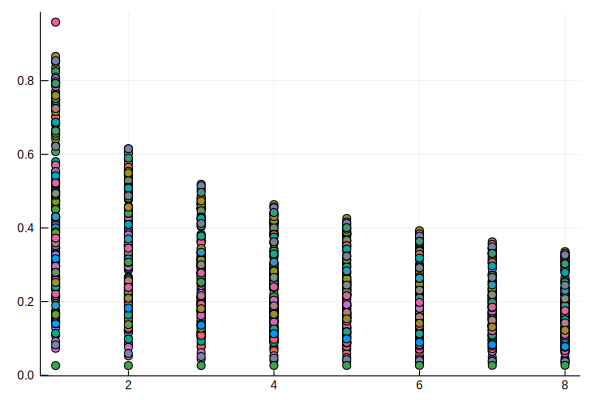

In [75]:
pp

In [35]:
xxx=[]
yyy=[]
gord1=[]
gord2=[]
for k in keys(hhsn)
    push!(xxx, k[2])
    push!(yyy, k[1])
    push!(gord1, hhsn[k][1])
    push!(gord2, hhsn[k][end])
end
    

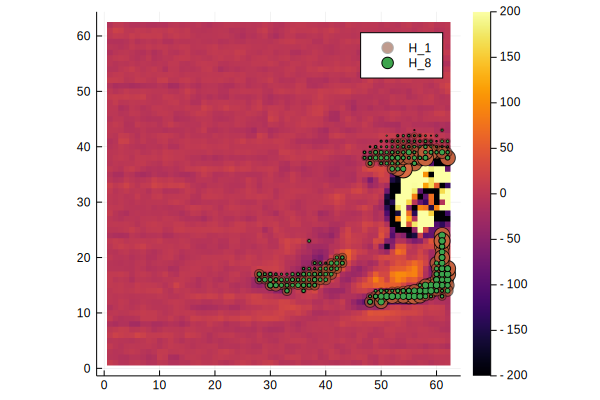

In [46]:
ppp=heatmap(csd[:,:,77], aspect_ratio=1, clims=(-200,200))
scatter!(xxx, yyy, markersize=gord1.*10, label="H_1", markeralpha=gord1)
scatter!(xxx, yyy, markersize=gord2.*10, label="H_8")


0.026838226810393995

In [56]:
max1=maximum(aar)
max8=maximum(bbr)

0.33574732277564123

In [59]:
for k in keys(hhsn)
    if hhsn[k][1]==min1
        print(k, " es el min de 1 bloque. ")
    elseif hhsn[k][1]==max1
        print(k, " es el max de 1 bloque. ")
    end
   if hhsn[k][8]==min8
        print(k, " es el min de 8 bloque. ")
    elseif hhsn[k][8]==max8
        print(k, " es el max de 8 bloque. ")
    end
end


[36, 54] es el max de 1 bloque. [24, 61] es el max de 8 bloque. [42, 51] es el min de 1 bloque. [42, 51] es el min de 8 bloque. 

In [ ]:
hhsn[:,:,1]==hhsn[:,:,4]

In [ ]:
allprobsn(xs, ss, 3)

In [ ]:
ss=[-1,0,1]
bla=[[q, j] for q in ss, j in ss ]

In [102]:
struct ONodo
    mesmo
end
a=ONodo(1)

ONodo(1)

In [101]:
?Nodo

search: Nodo unicodeplots UndefKeywordError ncodeunits QuoteNode invmod download



No documentation found.

# Summary

```
struct Nodo <: Any
```

# Fields

```
parent   :: Nodo
children :: Array{Nodo,1}
```


In [98]:
struct fobar
    fo
    bar
end

In [99]:
a=fobar(1,2)

fobar(1, 2)

In [46]:
problock(xs, [1]) , problock(xs, [0]),problock(xs, [-1])

(0.016129032258064516, 0.9556451612903226, 0.028225806451612902)

In [ ]:
heatmap(sumsym, aspect_ratio=1)

In [ ]:
?heatmap

In [68]:
a=[0,1]
n=[0, 1]
z=[1,1,0]
z2=[1,0,1]

3-element Array{Int64,1}:
 1
 0
 1

In [71]:
@time issubvec(a, z2)

  0.000008 seconds (9 allocations: 512 bytes)


true

In [72]:
@inbounds

LoadError: MethodError: no method matching @inbounds(::LineNumberNode, ::Module)
Closest candidates are:
  @inbounds(::LineNumberNode, ::Module, !Matched::Any) at essentials.jl:538

In [60]:
as=string(a)

"[0, 1]"